## **ssK36, analysis @Pixar**

## **Import modules**

In [2]:
import os
import sys

data_path=os.path.abspath('/media/dataHog/hca/SETD2') #Where your group data is
base_path=os.path.abspath('/media/dataHog/hca/SimFound_v2/source/') #Where your source code is (SFv2)

sys.path.append(base_path)
sys.path.append(data_path)

import importlib

import warnings
warnings.filterwarnings('ignore')
import Protocols as P

import main
import tools
import Trajectory
import MSM
import Featurize as F
import Discretize


from simtk.unit import *

## **Define Project**

In [3]:
importlib.reload(Trajectory)
importlib.reload(main)

workdir=data_path
results=workdir+'/results'
inputs=workdir+'/inputs/structures/'

protein=['ssK36']
parameters=['310K']
timestep=20*picoseconds

project=main.Project(title='ssk36', 
                     hierarchy=('protein', 'parameter'), 
                     workdir=workdir,
                     parameter=parameters, 
                     replicas=10, 
                     protein=protein, 
                     topology='ssK36_X.pdb',
                     timestep=timestep,
                    initial_replica=1)
project.setSystems()

Working on /media/dataHog/hca/SETD2
310K
Inputs:
/media/dataHog/hca/SETD2/inputs/structures
/media/dataHog/hca/SETD2/inputs/forcefields


## **Markov State Models**


In [4]:
importlib.reload(MSM)
importlib.reload(Trajectory)
import tools_plots
importlib.reload(tools_plots)

protein_regions = {'all' : 'protein and backbone'}

features_to_extract=['torsions', 'positions']


kinetic_models={}
kinetics=MSM.MSM(project,
                 protein_regions,
                 stride=1, 
                 timestep=timestep, 
                 warnings=True,
                def_traj=['production_NPT-1.dcd', 'production_NPT-2.dcd'])

Results will be stored under:  /media/dataHog/hca/SETD2/results/ssK36-310K/MSM
PyEMMA calculations will be stored under:  /media/dataHog/hca/SETD2/results/ssK36-310K/MSM/MSM_storage
Using pre-defined trajectory ['production_NPT-1.dcd', 'production_NPT-2.dcd'] and/or topology None


In [34]:
states = [5, 10, 15, 20, 30, 50, 100]
lags = [10, 100, 250, 500, 1000, 2000]
tica_lags=[10, 20, 50, 100, 200, 500, 1000, 2000]

test_models = []

for region in protein_regions.keys():
    for feature in features_to_extract:
        test_models.append((region, feature, states, lags))

kinetics.analysis(inputs=test_models, 
                    method='generate', 
                    tica_lag=tica_lags,
                    eval_vamps=True, 
                  tica_weights='empirical')

Executing load_models 
	Models calculated:  361
	Models to discard:  305
	Models to calculate:  0
	Failed models:  317
	Loaded models:  361
	Total number of models : 678


In [5]:
models=kinetics.model_comparison()
passed_models=models[models['Test'] == True]
failed_models=models[models['Test'] == False]
#ranked_models=passed_models.sort_values('Score', ascending=False)
passed_models

30 files collected.
Subset with VAMP2 cv


Discretized feature    feature name       model  Test  \
42        positions@200ps  positions  all     5@200ps  True   
43        positions@200ps  positions  all    10@200ps  True   
44        positions@200ps  positions  all    15@200ps  True   
45        positions@200ps  positions  all    20@200ps  True   
46        positions@200ps  positions  all    30@200ps  True   
...                   ...        ...  ...         ...   ...   
12589   positions@40000ps  positions  all  20@20000ps  True   
12590   positions@40000ps  positions  all  30@20000ps  True   
12593   positions@40000ps  positions  all   5@40000ps  True   
12594   positions@40000ps  positions  all  10@40000ps  True   
12595   positions@40000ps  positions  all  15@40000ps  True   

                                                 Filters  Processes  States  \
42     connectivity counts time_resolved reversible f...        3.0     5.0   
43     connectivity counts time_resolved reversible f...        8.0    10.0   
44     connectivity counts time_resolved reversible f...        6.0    15.0   
45     connectivity counts time_resolved reversible f...       11.0    20.0   
46     connectivity counts time_resolved reversible f...        9.0    30.0   
...                                                  ...        ...     ...   
12589  connectivity counts time_resolved reversible f...        3.0    20.0   
12590  connectivity counts time_resolved reversible f...        2.0    30.0   
12593  connectivity counts time_resolved reversible f...        2.0     5.0   
12594  connectivity counts time_resolved reversible f...        2.0    10.0   
12595  connectivity counts time_resolved reversible f...        4.0    15.0   

          Lag  Cluster method  Dimensions  tICA lag re-weighting   VAMP2cv  \
42       10.0             NaN        73.0      10.0      koopman   VAMP2 1   
43       10.0             NaN        73.0      10.0      koopman   VAMP2 1   
44       10.0             NaN        73.0      10.0      koopman   VAMP2 1   
45       10.0             NaN        73.0      10.0      koopman   VAMP2 1   
46       10.0             NaN        73.0      10.0      koopman   VAMP2 1   
...       ...             ...         ...       ...          ...       ...   
12589  1000.0             NaN        68.0    2000.0    empirical  VAMP2 10   
12590  1000.0             NaN        68.0    2000.0    empirical  VAMP2 10   
12593  2000.0             NaN        68.0    2000.0    empirical  VAMP2 10   
12594  2000.0             NaN        68.0    2000.0    empirical  VAMP2 10   
12595  2000.0             NaN        68.0    2000.0    empirical  VAMP2 10   

          Score  
42     4.363470  
43     8.135385  
44     8.709793  
45     9.157894  
46     9.538389  
...         ...  
12589  3.571043  
12590  2.777714  
12593  3.690898  
12594  4.244749  
12595  4.592852  

[3440 rows x 15 columns]

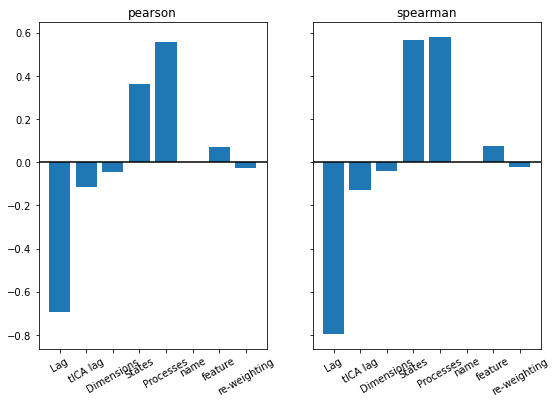

In [12]:
kinetics.plot_correlations(passed_models)

In [18]:
passed_models.hvplot.box(y='Score', by=['re-weighting', 'Lag'], rot=30)

:BoxWhisker   [re-weighting,Lag]   (Score)

In [19]:
passed_models.hvplot.box(y='Score', by=['re-weighting','tICA lag'], rot=30)

:BoxWhisker   [re-weighting,tICA lag]   (Score)

In [20]:
passed_models.hvplot.heatmap(x='Lag', y='tICA lag', C='Score', cmap='PRGn') + passed_models.hvplot.heatmap(x='Lag', y='States', C='Score', cmap='PRGn')

:Layout
   .HeatMap.I  :HeatMap   [Lag,tICA lag]   (Score)
   .HeatMap.II :HeatMap   [Lag,States]   (Score)

In [21]:
top_models=passed_models[(passed_models.Lag <= 500) & (passed_models.States < 120) & (passed_models['tICA lag'] <= 2000) & (passed_models.feature == 'torsions')]
passed_models.hvplot.box(by=['re-weighting', 'feature'],y='Score')

:BoxWhisker   [re-weighting,feature]   (Score)

In [23]:
top_models.hvplot.box(y='Score', by=['Lag', 'States'], rot=30) + top_models.hvplot.box(y='Score', by=['tICA lag', 'States'], rot=30) 

:Layout
   .BoxWhisker.I  :BoxWhisker   [Lag,States]   (Score)
   .BoxWhisker.II :BoxWhisker   [tICA lag,States]   (Score)

In [24]:
top_models.hvplot.heatmap(y='Lag', x='tICA lag', C='Score', groupby=['re-weighting','States'], cmap='PRGn') 

:DynamicMap   [re-weighting,States]
   :HeatMap   [tICA lag,Lag]   (Score)

In [25]:
top_model = [('all', 'torsions', 100, 10, (2,5))] #tICA lag 100, koopman
tica_lag = 200

## CK test

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
Executing load_discretized_data 
	Found TICA of all_torsions@4000ps_w-koopman_s1
	Total number of frames: 49998
	Number of trajectories: 20
	Frames/trajectory: [2499, 2500]
Executing CKTest_calculation 
	CK test: all_torsions@4000ps_w-koopman_s1_100@200ps -> 2 macrostates


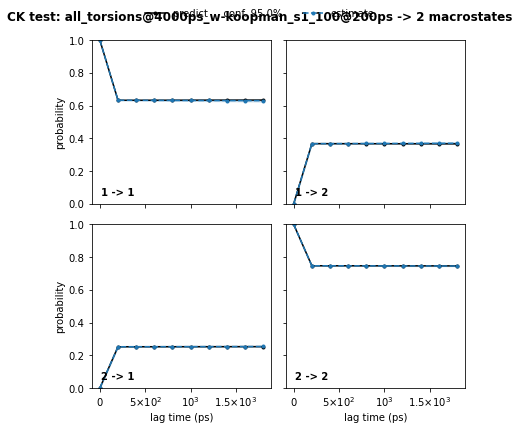

	CK test: all_torsions@4000ps_w-koopman_s1_100@200ps -> 3 macrostates


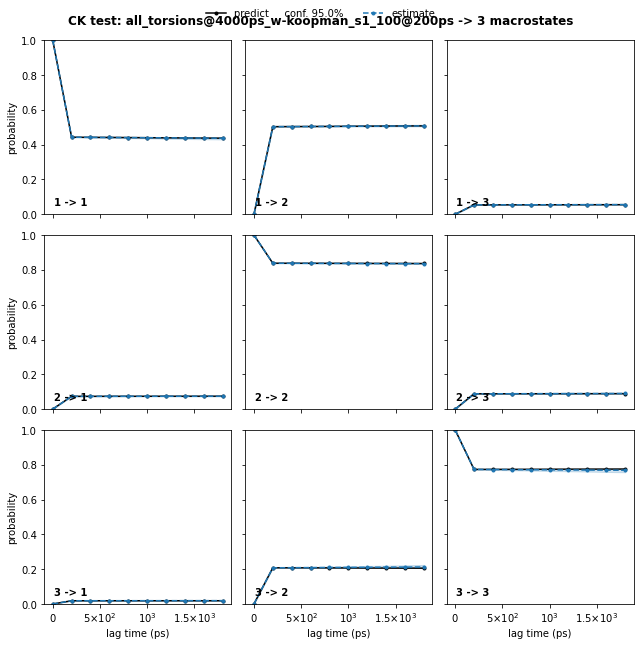

	CK test: all_torsions@4000ps_w-koopman_s1_100@200ps -> 4 macrostates


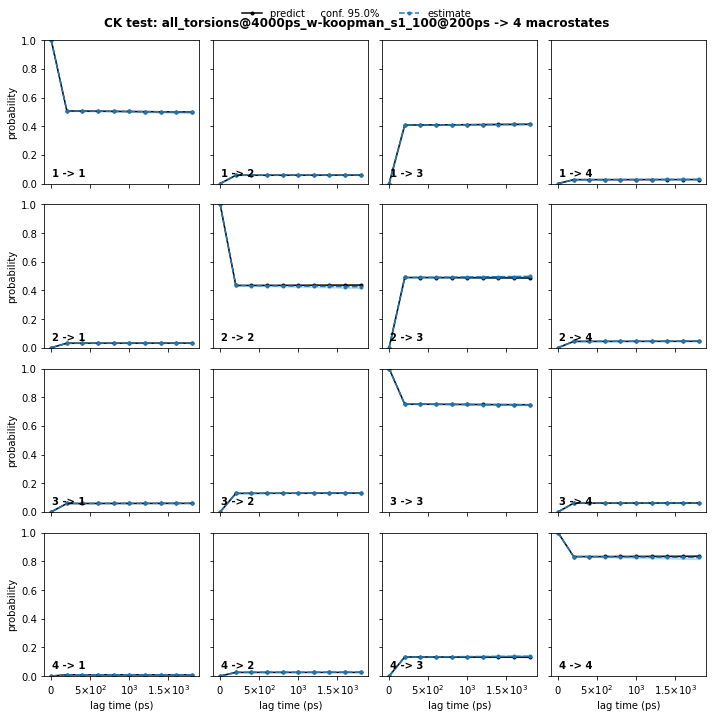

	CK test: all_torsions@4000ps_w-koopman_s1_100@200ps -> 5 macrostates


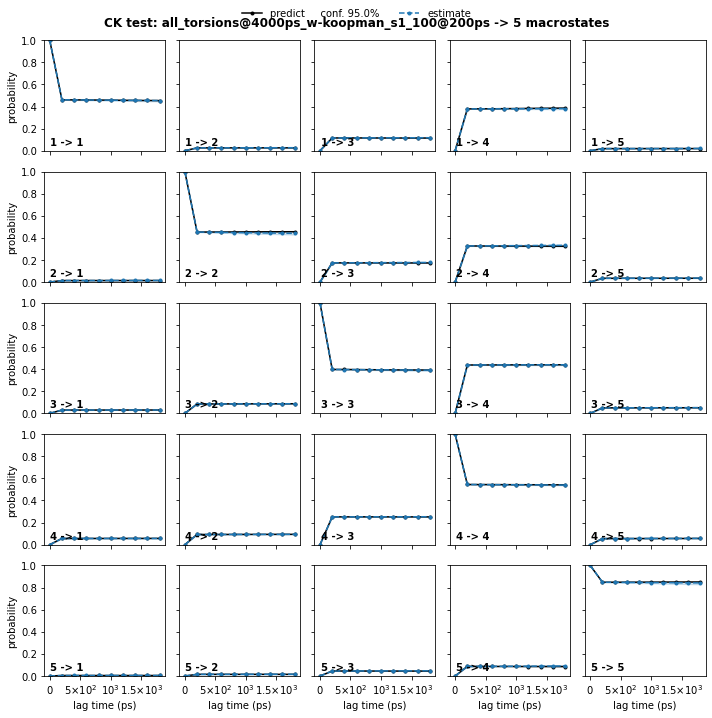

In [27]:
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='CKtest')

## PCCA

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
Executing load_discretized_data 
	Found TICA of all_torsions@4000ps_w-koopman_s1
	Total number of frames: 49998
	Number of trajectories: 20
	Frames/trajectory: [2499, 2500]
Executing PCCA_calculation 
	PCCA with 2 MSfor 100 cluster centers


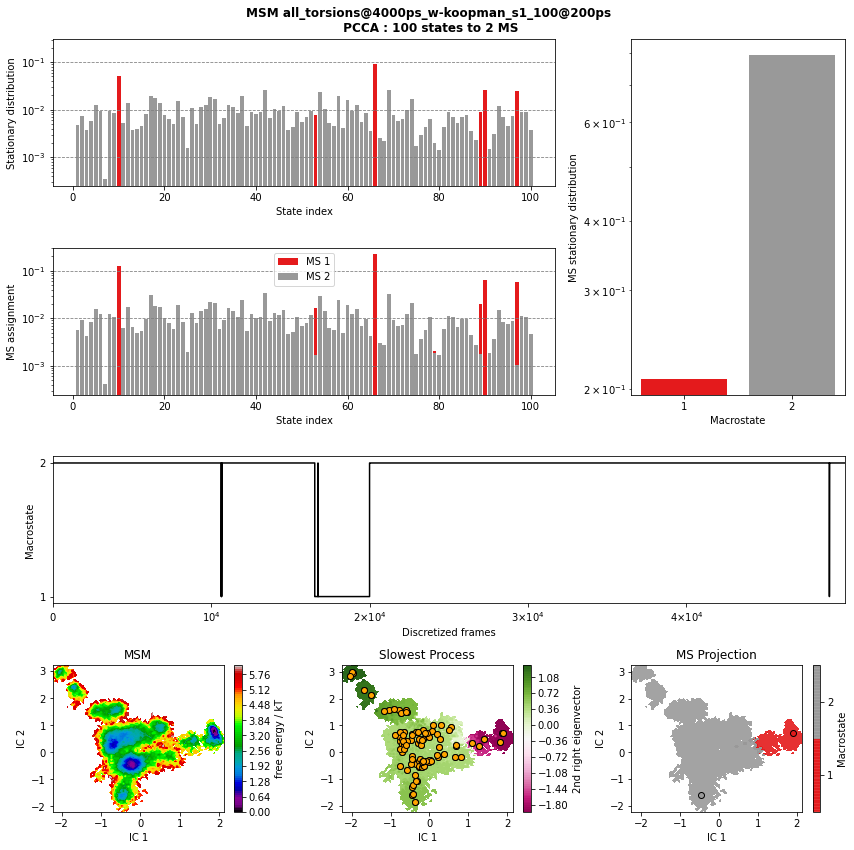

	PCCA with 3 MS


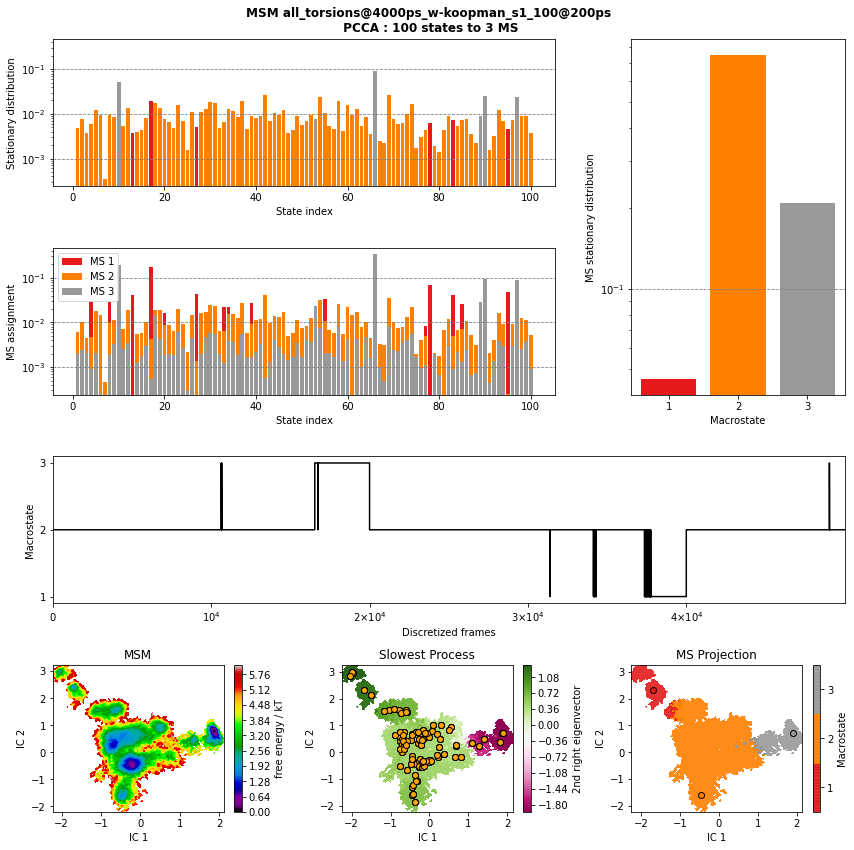

	PCCA with 4 MS


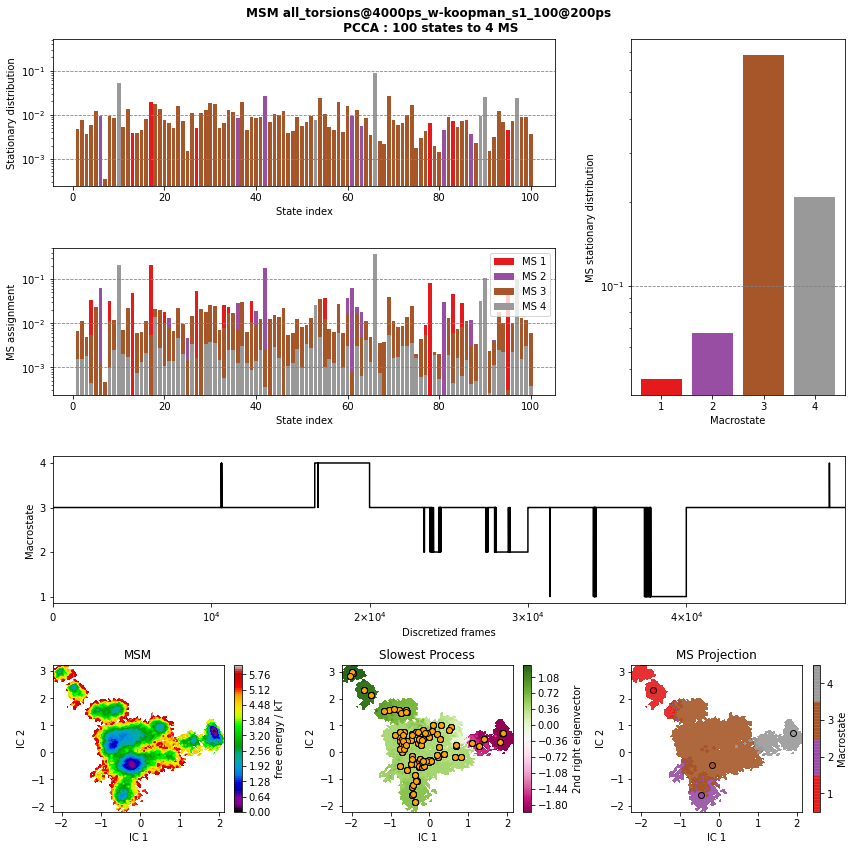

	PCCA with 5 MS


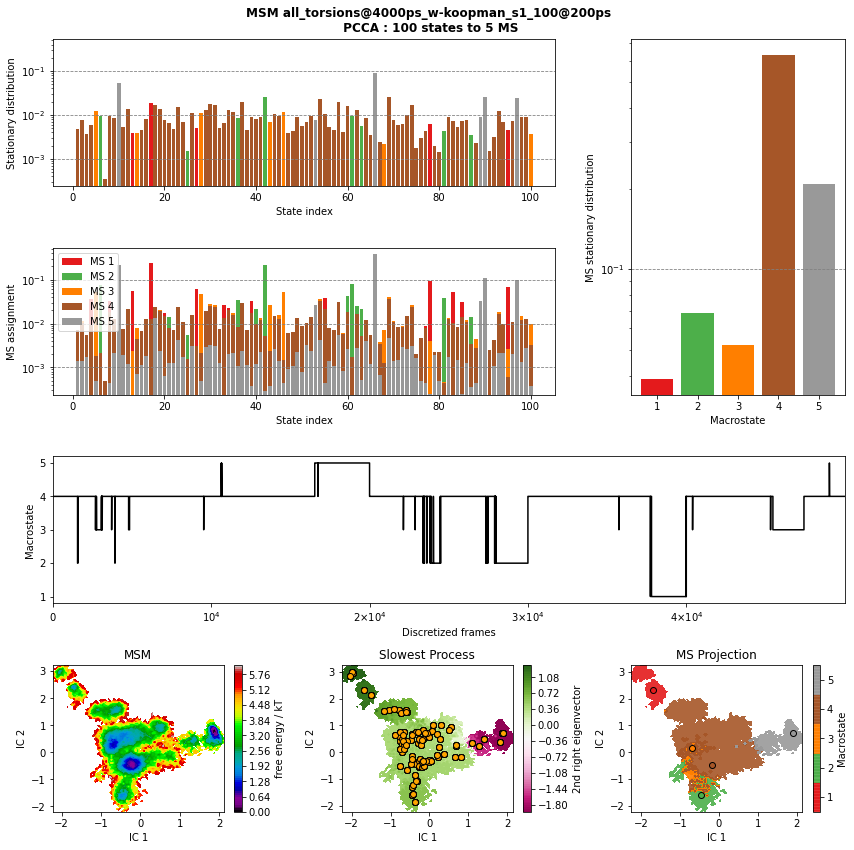

In [30]:
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='PCCA')

In [36]:
top_model = [('all', 'torsions', 100, 10, 4)] #tICA lag 100, koopman
tica_lag = 200

## MFPT

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
Executing MFPT_calculation 
	Calculating MFPT matrix...
		transition: 100 -> 1   



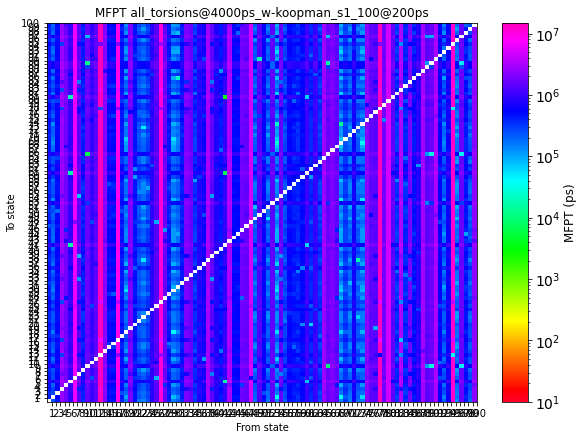

Coarse-graining with PCCA
Transition MS: 4 -> 4



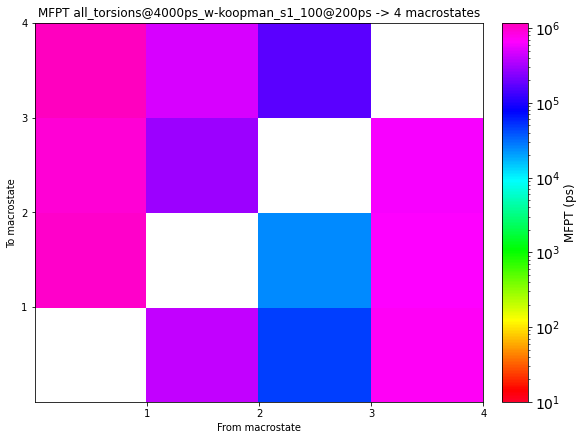

In [39]:
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='MFPT')

## TPT

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
Executing flux_calculation 
	Performing coarse-grained TPT from A->I->B
	A = ['MS 4']
	B = ['MS 1']
	I = ['MS 3', 'MS 2']
	Generating TPT trajectory 


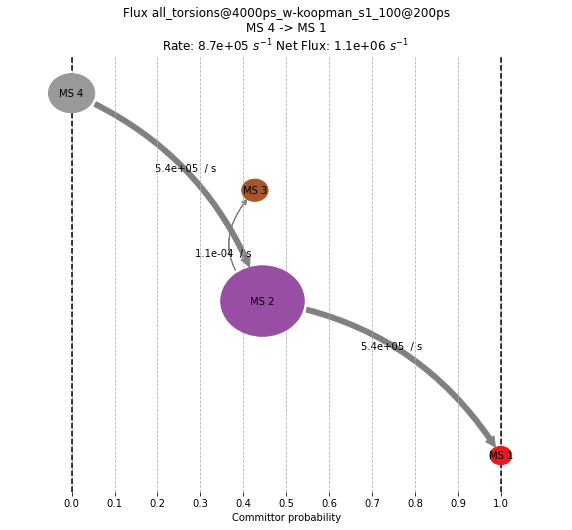

                             net flux           rate
name feature  model                                 
all  torsions 100@200ps  1.085197e+06  870253.955864
                                 Forward  Backward
name feature  model     states                    
all  torsions 100@200ps MS 4    0.000000  1.000000
                        MS 3    0.427039  0.572961
                        MS 2    0.444763  0.555237
                        MS 1    1.000000  0.000000
                                              % Total
name feature  model     pathway                      
all  torsions 100@200ps MS 4 -> MS 2 -> MS 1    100.0


In [37]:
top_model = [('all', 'torsions', 100, 10, 4, [[4], [1]])] 
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='flux')

In [38]:
kinetics.analysis(inputs=top_model, tica_weights='koopman', tica_lag=tica_lag, method='get_samples')

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
	Generating 10*4macrostates = 40 samples from metastable distributions


## Evaluate *features* and *dimensions* with VAMP2 scores

In [ ]:
vamp_lags=[1, 2, 10, 50, 100, 200, 500, 1000]
kinetics.calculate(method='VAMP', 
                    evaluate=['features', 'dimensions'], 
                    features=features_to_extract, 
                    VAMP_lags=vamp_lags, 
                    dim=0.95,
                    def_traj=['production_NPT-1.dcd', 'production_NPT-2.dcd'])

## Implied Timescales

In [ ]:
region_states = {'all' : 20}
kinetics.calculate(inputs=region_states, 
                   method='ITS', 
                   features=features_to_extract, 
                   TICA_lag=10)

## Spectral Analysis

In [ ]:
test_models = [('all', 'torsions', [5, 10,15,20, 30], [50, 100,250,500]),
              ('all', 'positions', [5, 10,15,20, 30], [50, 100,250,500])] 
disc_lags=[10, 20, 50, 100, 200, 500, 1000, 2000]
for lag in disc_lags:
    kinetics.analysis(inputs=test_models, 
                      method='Spectral',
                      disc_lag=lag,
                      eval_vamps=True)

## Visualization

In [ ]:
for tica_lag, input_models in top_models.items():
    view=kinetics.analysis(inputs=input_models, disc_lag=tica_lag, method='Visual')

In [ ]:
view

In [ ]:
view2['post_SET_domain-positions@4000 ps-4']

## RMSD

In [ ]:
pdb = ['h3k36_ext', 'ssK36_complexed', 'H3K36_complexed', 'H3K36M_complexed']
for tica_lag, input_models in top_models.items():
    kinetics.analysis(inputs=input_models, disc_lag=tica_lag, method='RMSD', compare_pdbs = pdb)

In [ ]:
top_models = {10 : [('all', 'positions', 30, 50, 3, ([2], [3]))]}

In [ ]:
for tica_lag, input_models in top_models.items():
    kinetics.analysis(inputs=input_models, disc_lag=tica_lag, method='flux')

## RDF

In [7]:
importlib.reload(Trajectory)
importlib.reload(F)

featurize=F.Featurize(project, results=results, timestep=timestep, warnings=True, heavy_and_fast=False)

rdf = featurize.calculate(('protein and not name H*', 'resname HOH and type O'), 
                    method='RDF',  
                    n_cores=4,
                    feature_name='SolvationShell',
                    def_traj=['production_NPT-1.dcd', 'production_NPT-2.dcd'])
rdf

Results will be stored under:  /media/dataHog/hca/SETD2/results/ssK36-310K
Loading pre-calculated RDF dataframe
l1        ssK36                                                              \
l2         310K                                                               
l3            1         2         3         4         5         6         7   
$G_r$                                                                         
0.1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.7    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.9    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
14.1   0.965166  0.964927  0.964873  0.966157  0.968466  0.964046  0.971084   
14.3   0.967659  0.

l1        ssK36                                                              \
l2         310K                                                               
l3            1         2         3         4         5         6         7   
$G_r$                                                                         
0.1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.7    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.9    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
14.1   0.965166  0.964927  0.964873  0.966157  0.968466  0.964046  0.971084   
14.3   0.967659  0.967385  0.966701  0.968706  0.969924  0.966414  0.972155   
14.5   0.969413  0.968963  0.969228  0.971770  0.972004  0.968425  0.974973   
14.7   0.971121  0.971476  0.970557  0.973602  0.973488  0.969630  0.976708   
14.9   0.972515  0.973200  0.972840  0.975122  0.974323  0.972279  0.977907   

l1                                   
l2                                   
l3            8         9        10  
$G_r$                                
0.1    0.000000  0.000000  0.000000  
0.3    0.000000  0.000000  0.000000  
0.5    0.000000  0.000000  0.000000  
0.7    0.000000  0.000000  0.000000  
0.9    0.000000  0.000000  0.000000  
...         ...       ...       ...  
14.1   0.965766  0.971492  0.964697  
14.3   0.968159  0.973579  0.966859  
14.5   0.970045  0.975356  0.968479  
14.7   0.972166  0.975712  0.970065  
14.9   0.973875  0.977206  0.972294  

[75 rows x 10 columns]

In [8]:
rdf_reset=rdf.droplevel(level=[0,1], axis=1) 

In [9]:
rdf_reset.hvplot()

:NdOverlay   [l3]
   :Curve   [$G_r$]   (value)

# 